<a href="https://colab.research.google.com/github/ads-ayaz/ml-playbook/blob/master/20200611_Music_classification_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Music Classification on GTZAN Data</strong> | Aluance Digital</h1>

Machine learning projects have a lot of steps and stages to them. Executing a successful project can be made a whole lot easier when you have a framework that organizes the whole approach.

That's why Aluance developed this "playbook" it simultaneously acts as a machine learning project template and a collection of best practices. The playbook is continually updated, and can be forked whenever a new project is initiated.

# How to use this playbook

# Problem statement

# Libraries

Install or upgrade missing libraries.

In [1]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
#!pip install --upgrade tensorflow

!pip show Keras
#!pip install --upgrade Keras

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, opt-einsum, protobuf, google-pasta, tensorflow-estimator, astunparse, grpcio, absl-py, gast, wheel, h5py, keras-preprocessing, termcolor, wrapt, scipy, tensorboard, numpy
Required-by: fancyimpute
Name: Keras
Version: 2.3.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, numpy, keras-applications, six, keras-preprocessing, scipy, pyyaml
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


Import the libraries needed for this project.

In [2]:
import os

import numpy as np
import pandas as pd

import keras
from keras.layers import Dense             # Dense describes how the layers are connected
from keras.models import Sequential        # Sequential means we are creating a sequence of connectec layers
from keras.optimizers import SGD           # Sochastic gradient descent is the method used to find local minimum
#from tensorflow.keras.optimizers.schedules import ExponentialDecay    # Used for schedules.ExponentialDecay

import matplotlib.pyplot as plt            # visualize images

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

Using TensorFlow backend.


# Data preparation

## Acquisition

After uploading the source data file, use the following commands to unzip the contents into the `data` folder.


In [3]:
# Uncomment the lines below to execute.
!mkdir /content/data
!unzip /content/drive/My\ Drive/_ml/_datasets/GTZAN\ dataset\ -\ 568973_1032238_bundle_archive.zip -d /content/data

Archive:  /content/drive/My Drive/_ml/_datasets/GTZAN dataset - 568973_1032238_bundle_archive.zip
  inflating: /content/data/Data/features_30_sec.csv  
  inflating: /content/data/Data/features_3_sec.csv  
  inflating: /content/data/Data/genres_original/blues/blues.00000.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00001.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00002.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00003.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00004.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00005.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00006.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00007.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00008.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00009.wav  
  inflating: /content/data/Data/genres_original/blues/blues.00010.wav  
  i

## Unpacking the data

The GTZAN data set includes a folder called `genres_original` that categorizes 30 second music samples in folders labeled by genre. Each sample is a `.wav` file, whose filename follows the format `<genre_label>.<num_id>.wav`. The collection comprises 10 genres folders each containing 100 audio files.

The `images_original` folder contains a Mel Spectogram image in `.png` format for each music sample. Each spectogram provides a visual representation for one of the audio files. The files are organized into folders by genre and the file naming convention is `<genre_label><num_id>.png`, where the num_ids match those of the corresponding  music sample audio files.

The data set also comes with two `.csv` files that list features for the music samples in either their full 30 second format (`features_30_sec.csv`) or in 3 second segments (`features_3_sec.csv`). Breaking the samples up effectively tripples the available data samples to 3,000.

Here are the fields that each of the `.csv` files contain:

| Field | Format | Description | Notes |
| --- | --- | --- | --- |
| filename | string | Name of the music sample `.wav` file.|Segments in the `3_sec` file denoted<br/> as `<fname>.<segment>.wav`. |
| length | int | Size of the file in bytes | [CHECK] |
| chroma_stft_mean<br/>chroma_stft_var | float | The mean and variance of the _chroma_ of the audio sample. | See: [Wikipedia](https://en.wikipedia.org/wiki/Chroma_feature)|
| rms_mean<br/>rms_var | float |||
| spectral_centroid_mean<br/>spectral_centroid_var | float |||
| spectral_bandwidth_mean<br/>spectral_bandwidth_var | float |||
| rolloff_mean<br/>rolloff_var | float |||
| zero_crossing_rate_mean<br/>zero_crossing_rate_var | float |||
| harmony_mean<br/>harmony_var | float |||
| perceptr_mean<br/>perceptr_var | float |||
| tempo | float | The _tempo_ or speed of the beat in BPM. ||
| mfcc00_var<br/>mfcc00_mean | float | Mean and variance of **mel-frequency cepstral coefficients**. | See: [Wikipedia](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) |
| label | string | Musical genre of the sample. ||


## Import

In [0]:
FOLDER_pwd = os.getcwd()
FOLDER_data_root = "data/"
FOLDER_csv = FOLDER_data_root + "Data/"

FILE_features30 = "features_30_sec.csv"
FILE_features3 = "features_3_sec.csv"

In [0]:
# Import using NumPy
# raw_data = np.genfromtxt(FOLDER_csv + FILE_features3, delimiter=',')
# raw_data = raw_data[1:, 2:]
# np.shape(raw_data)

OBSERVATIONS
* Removing the _mean_ feaures reduces the noisiness of the outcome. In contrast the _var_ values appear to drive performance of the model.

In [0]:
# Import using Pandas
df_raw = pd.read_csv(FOLDER_csv + FILE_features3)

# Create X as matrix of [n_features, m_examples], dropping some cols
df_X_raw = df_raw.drop(['filename', 'length', 'label'], axis=1)

# Remove all the var features
#df_X_raw = df_X_raw.drop(['chroma_stft_var', 'rms_var', 'spectral_centroid_var', 'spectral_bandwidth_var', 'rolloff_var', 'zero_crossing_rate_var', 'harmony_var', 'perceptr_var', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var', 'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 'mfcc13_var', 'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var', 'mfcc19_var', 'mfcc20_var'], axis=1)
# Remove all the mean features
df_X_raw = df_X_raw.drop(['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 'rolloff_mean', 'zero_crossing_rate_mean', 'harmony_mean', 'perceptr_mean', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean', 'mfcc19_mean', 'mfcc20_mean'], axis=1)

# Create Y as matrix of [1, m] labels
df_Y_raw = pd.DataFrame(df_raw['label'])
#Y_raw = np.reshape(np.array(df_raw['label']), (np.shape(X_raw)[0], 1))

# Shuffle X, Y
df_X, df_Y = shuffle(df_X_raw, df_Y_raw)

In [7]:
df_X

,chroma_stft_var,rms_var,spectral_centroid_var,spectral_bandwidth_var,rolloff_var,zero_crossing_rate_var,harmony_var,perceptr_var,tempo,mfcc1_var,mfcc2_var,mfcc3_var,mfcc4_var,mfcc5_var,mfcc6_var,mfcc7_var,mfcc8_var,mfcc9_var,mfcc10_var,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
4002,0.092254,0.001942,358342.061462,91236.879030,1.395574e+06,0.002757,0.002054,0.008853,117.453835,3092.523193,440.443573,427.138092,233.099136,215.227798,137.271042,113.081299,104.224380,69.614273,63.686478,43.905663,82.501312,58.960316,87.638969,80.723175,83.807770,92.450317,61.226288,63.197372,54.312923
1612,0.082433,0.000209,16910.939740,21514.899497,4.033773e+04,0.000175,0.001457,0.000091,151.999081,1961.290894,112.575958,81.947624,62.150471,45.205933,36.944691,30.900118,35.845314,34.823349,42.573025,41.512596,55.064934,54.379208,76.554886,86.987976,52.604385,106.445541,103.119591,78.194397,65.543762
2101,0.092185,0.001120,486796.300580,179634.303522,2.243204e+06,0.001030,0.004653,0.000500,80.749512,3352.528320,941.402527,404.561768,132.034256,278.912933,112.693420,107.016953,83.266853,124.860413,233.552399,55.868690,82.466331,43.994637,41.010044,63.778397,47.047836,75.300026,31.837368,19.023922,40.244225
7004,0.101111,0.014581,882768.615630,100174.786354,1.020691e+06,0.010506,0.029941,0.031511,107.666016,4270.247070,1037.137573,920.687561,485.731964,269.881836,253.648254,143.253555,127.312752,160.271362,124.815674,89.439354,103.760605,78.582138,93.339920,122.660004,161.504532,260.249512,145.480392,116.747002,120.745819
5210,0.068022,0.000116,144139.451886,7395.757644,1.258772e+05,0.003144,0.001228,0.000342,129.199219,488.363708,181.232605,163.671356,51.391445,31.176311,16.547997,26.293875,15.637846,38.021885,18.335217,24.352573,33.879032,12.921805,33.436794,20.817688,17.588390,20.817541,14.170851,23.836195,19.414816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0.077935,0.001471,312590.319032,116903.227193,1.183323e+06,0.002039,0.012758,0.004762,123.046875,995.353699,510.496765,299.254730,132.824997,83.646790,49.465359,52.499466,34.266220,44.776970,30.210690,37.633301,35.773937,33.898956,23.716883,50.887810,24.532743,28.121546,34.093033,57.371159,39.351128
3873,0.082266,0.000650,182694.847735,68309.443565,1.009379e+06,0.001279,0.005707,0.004071,107.666016,740.614441,378.263214,192.072708,159.661148,64.754288,99.210022,81.755493,41.149403,54.566128,54.006889,31.902765,31.934338,34.386559,43.427238,34.277615,45.741894,33.169407,46.266914,58.749187,44.610645
2602,0.075468,0.001638,237347.918146,211933.235499,2.035661e+06,0.000287,0.013222,0.001560,69.837416,3406.293701,583.283142,152.641922,84.575150,121.282265,49.619713,77.416344,91.348091,87.433113,222.865509,105.097870,97.567444,118.713448,79.145294,49.282158,15.356136,83.514664,53.287594,30.523855,58.466278
641,0.081716,0.000663,161807.609279,39902.806187,4.259998e+05,0.001390,0.005319,0.002948,78.302557,1022.485107,208.823318,182.256729,113.249779,53.918476,32.636597,49.619560,48.316093,39.561539,34.247448,40.967136,34.811802,44.431385,32.931622,26.177185,34.413815,32.070621,34.167355,35.276367,31.376127


In [0]:
# Normalize X

def normalize(X) :
  epsilon = np.power([10.0], -7)
  n, m = np.shape(X)
  mu = (1 / m) * np.mean(X)
  sigma_sq = (1 / m) * np.sum(np.power(X, 2))
  X = (X - mu) / (sigma_sq + epsilon)
  return X

df_X = normalize(df_X)

In [9]:
df_X

,chroma_stft_var,rms_var,spectral_centroid_var,spectral_bandwidth_var,rolloff_var,zero_crossing_rate_var,harmony_var,perceptr_var,tempo,mfcc1_var,mfcc2_var,mfcc3_var,mfcc4_var,mfcc5_var,mfcc6_var,mfcc7_var,mfcc8_var,mfcc9_var,mfcc10_var,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
4002,0.035537,0.268276,2.752335e-09,1.042967e-08,7.982221e-10,0.388562,0.014771,0.332334,0.000020,5.944109e-07,2.185759e-06,5.304712e-06,0.000013,0.000019,0.000022,0.000023,0.000038,0.000026,0.000027,0.000021,0.000049,0.000036,0.000057,0.000055,0.000065,0.000065,0.000041,0.000037,0.000028
1612,0.031630,0.016878,2.034734e-11,2.086518e-09,-9.432380e-12,0.012282,0.009324,-0.003922,0.000026,3.699476e-07,4.800439e-07,8.842066e-07,0.000003,0.000004,0.000006,0.000006,0.000013,0.000012,0.000018,0.000020,0.000032,0.000033,0.000050,0.000059,0.000040,0.000075,0.000070,0.000047,0.000034
2101,0.035510,0.149047,3.780172e-09,2.100759e-08,1.303368e-09,0.136880,0.038476,0.011789,0.000013,6.460021e-07,4.791972e-06,5.015600e-06,0.000007,0.000024,0.000018,0.000021,0.000030,0.000047,0.000103,0.000027,0.000049,0.000027,0.000026,0.000043,0.000036,0.000053,0.000021,0.000010,0.000020
7004,0.039061,2.101044,6.948576e-09,1.149921e-08,5.748101e-10,1.517708,0.269120,1.201933,0.000018,8.280993e-07,5.290029e-06,1.162510e-05,0.000027,0.000024,0.000042,0.000029,0.000047,0.000061,0.000055,0.000045,0.000062,0.000049,0.000061,0.000084,0.000126,0.000186,0.000099,0.000070,0.000063
5210,0.025897,0.003422,1.038376e-09,3.969759e-10,4.154493e-11,0.444994,0.007240,0.005704,0.000022,7.768387e-08,8.372266e-07,1.930760e-06,0.000003,0.000002,0.000002,0.000005,0.000005,0.000014,0.000007,0.000011,0.000020,0.000007,0.000021,0.000013,0.000012,0.000014,0.000009,0.000013,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0.029841,0.199994,2.386249e-09,1.350099e-08,6.717312e-10,0.283929,0.112398,0.175344,0.000021,1.782827e-07,2.550207e-06,3.667039e-06,0.000007,0.000007,0.000008,0.000010,0.000012,0.000016,0.000012,0.000018,0.000021,0.000020,0.000015,0.000034,0.000018,0.000019,0.000022,0.000034,0.000020
3873,0.031564,0.080910,1.346880e-09,7.686102e-09,5.680686e-10,0.173241,0.048089,0.148812,0.000018,1.277364e-07,1.862268e-06,2.294467e-06,0.000009,0.000005,0.000016,0.000016,0.000015,0.000020,0.000023,0.000015,0.000018,0.000021,0.000028,0.000023,0.000035,0.000023,0.000031,0.000035,0.000023
2602,0.028859,0.224190,1.784191e-09,2.487258e-08,1.179683e-09,0.028676,0.116625,0.052472,0.000011,6.566704e-07,2.928874e-06,1.789517e-06,0.000004,0.000010,0.000008,0.000015,0.000033,0.000033,0.000099,0.000053,0.000058,0.000075,0.000052,0.000033,0.000011,0.000059,0.000035,0.000017,0.000030
641,0.031345,0.082755,1.179749e-09,4.286873e-09,2.204034e-10,0.189382,0.044552,0.105713,0.000013,1.836662e-07,9.807659e-07,2.168764e-06,0.000006,0.000004,0.000005,0.000010,0.000017,0.000014,0.000014,0.000020,0.000020,0.000027,0.000021,0.000017,0.000026,0.000022,0.000022,0.000020,0.000016


In [0]:
# Construct a dictionary from all the possible labels in Y
dictLabels = dict(map(reversed, enumerate(list(set(df_Y_raw['label'])))))

In [0]:
# Split the dataset into train, dev and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.8, shuffle=False)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

# One-hot encode the y sets
s = pd.Series(dictLabels)
y_train = keras.utils.to_categorical(s[y_train['label']])
y_dev = keras.utils.to_categorical(s[y_dev['label']])
y_test = keras.utils.to_categorical(s[y_test['label']])


# Model

In [0]:
# Get the shape of the data
m_train, n = np.shape(X_train)
m_dev, _ = np.shape(X_dev)
m_test, _ = np.shape(X_test)

In [13]:
X_train

,chroma_stft_var,rms_var,spectral_centroid_var,spectral_bandwidth_var,rolloff_var,zero_crossing_rate_var,harmony_var,perceptr_var,tempo,mfcc1_var,mfcc2_var,mfcc3_var,mfcc4_var,mfcc5_var,mfcc6_var,mfcc7_var,mfcc8_var,mfcc9_var,mfcc10_var,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
4002,0.035537,0.268276,2.752335e-09,1.042967e-08,7.982221e-10,0.388562,0.014771,0.332334,0.000020,5.944109e-07,2.185759e-06,5.304712e-06,0.000013,0.000019,0.000022,0.000023,0.000038,0.000026,0.000027,0.000021,0.000049,0.000036,0.000057,0.000055,0.000065,0.000065,0.000041,0.000037,0.000028
1612,0.031630,0.016878,2.034734e-11,2.086518e-09,-9.432380e-12,0.012282,0.009324,-0.003922,0.000026,3.699476e-07,4.800439e-07,8.842066e-07,0.000003,0.000004,0.000006,0.000006,0.000013,0.000012,0.000018,0.000020,0.000032,0.000033,0.000050,0.000059,0.000040,0.000075,0.000070,0.000047,0.000034
2101,0.035510,0.149047,3.780172e-09,2.100759e-08,1.303368e-09,0.136880,0.038476,0.011789,0.000013,6.460021e-07,4.791972e-06,5.015600e-06,0.000007,0.000024,0.000018,0.000021,0.000030,0.000047,0.000103,0.000027,0.000049,0.000027,0.000026,0.000043,0.000036,0.000053,0.000021,0.000010,0.000020
7004,0.039061,2.101044,6.948576e-09,1.149921e-08,5.748101e-10,1.517708,0.269120,1.201933,0.000018,8.280993e-07,5.290029e-06,1.162510e-05,0.000027,0.000024,0.000042,0.000029,0.000047,0.000061,0.000055,0.000045,0.000062,0.000049,0.000061,0.000084,0.000126,0.000186,0.000099,0.000070,0.000063
5210,0.025897,0.003422,1.038376e-09,3.969759e-10,4.154493e-11,0.444994,0.007240,0.005704,0.000022,7.768387e-08,8.372266e-07,1.930760e-06,0.000003,0.000002,0.000002,0.000005,0.000005,0.000014,0.000007,0.000011,0.000020,0.000007,0.000021,0.000013,0.000012,0.000014,0.000009,0.000013,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,0.031239,0.157172,5.313715e-09,1.077827e-08,1.024610e-09,0.689985,0.061478,0.104674,0.000021,3.174310e-07,2.719441e-06,1.638166e-06,0.000007,0.000007,0.000012,0.000009,0.000028,0.000015,0.000014,0.000016,0.000025,0.000017,0.000022,0.000021,0.000040,0.000021,0.000025,0.000017,0.000022
6136,0.024323,0.002450,5.480509e-10,3.193683e-09,1.601123e-10,0.095118,0.028071,0.020472,0.000027,7.667870e-08,1.135734e-06,1.371654e-06,0.000002,0.000003,0.000006,0.000008,0.000016,0.000004,0.000019,0.000011,0.000024,0.000014,0.000029,0.000019,0.000021,0.000010,0.000042,0.000012,0.000029
374,0.037292,0.323819,3.023162e-09,2.979815e-08,2.120955e-09,0.152057,0.042660,0.018795,0.000014,1.862763e-06,3.108582e-06,1.018679e-05,0.000006,0.000016,0.000051,0.000034,0.000044,0.000050,0.000028,0.000070,0.000088,0.000069,0.000067,0.000070,0.000136,0.000182,0.000135,0.000075,0.000097
9446,0.029583,0.075048,2.989175e-10,5.094488e-10,2.521809e-11,0.079383,0.058936,0.030908,0.000026,2.101787e-07,8.821436e-07,5.128369e-07,0.000002,0.000005,0.000005,0.000006,0.000010,0.000011,0.000012,0.000008,0.000011,0.000009,0.000009,0.000009,0.000007,0.000009,0.000010,0.000008,0.000006


### Hyperparameter configuration (30-second samples)

In [0]:
# # Nodes per layer
# n_layer = [n, 128, 128, 128, 10]

# # Set up a decaying learning rate
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=1000,
#     decay_rate=0.97,
#     staircase=False)

# # Hyperparamerters
# hyper = {}
# hyper["alpha"] = lr_schedule #0.0001              # Learning rate
# hyper["batch_size"] = 32              # Mini-batch size
# hyper["epochs"] = 1500                 # Training epochs
# hyper["lambda_l2"] = 0.0065                # lambda for L2 regularization
# hyper["loss"] ="categorical_crossentropy"
# hyper["L"] = len(n_layer)             # Number of layers in the model
# hyper["metrics"] =["accuracy", "categorical_accuracy"]
# hyper["momentum"] = 0.9             # momentum for SGD
# hyper["nesterov"] = True           # use Nesterov momentum?

### Hyperparameter configuration (3-second samples)

In [0]:
# Nodes per layer
n_layer = [n, 128, 64, 10]

# Set up a decaying learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

# Hyperparamerters
hyper = {}
hyper["alpha"] = lr_schedule #0.001              # Learning rate
hyper["batch_size"] = 128              # Mini-batch size
hyper["epochs"] = 1500                 # Training epochs
hyper["lambda_l2"] = 0.0 #0.001                # lambda for L2 regularization
hyper["loss"] ="categorical_crossentropy"
hyper["L"] = len(n_layer)             # Number of layers in the model
hyper["metrics"] =["categorical_accuracy"]
hyper["momentum"] = 0.9             # momentum for SGD
hyper["nesterov"] = True           # use Nesterov momentum?

### Build the layers

In [16]:
model = Sequential()
model.add(Dense(input_shape=(n_layer[0],), activation='relu', units=n_layer[0], kernel_regularizer=keras.regularizers.l2(l=hyper["lambda_l2"])))
for l in range(1, (hyper["L"] - 1)):
  model.add(Dense(activation='relu', units=n_layer[l], kernel_regularizer=keras.regularizers.l2(l=hyper["lambda_l2"])))
model.add(Dense(activation='softmax',units=n_layer[hyper["L"] - 1], kernel_regularizer=keras.regularizers.l2(l=hyper["lambda_l2"])))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3840      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 13,616
Trainable params: 13,616
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=hyper["alpha"], 
        momentum=hyper["momentum"], 
        nesterov=hyper["nesterov"]), 
    loss=hyper["loss"],
    metrics=hyper["metrics"])

# Training

In [18]:
history = model.fit(X_train, y_train,
                    batch_size=hyper["batch_size"],
                    epochs=hyper["epochs"],
                    verbose=2, 
                    validation_data=(X_dev, y_dev),
                    validation_freq=1)

Train on 1998 samples, validate on 3996 samples
Epoch 1/1500
 - 2s - loss: 2.3077 - categorical_accuracy: 0.1126 - val_loss: 2.3050 - val_categorical_accuracy: 0.1401
Epoch 2/1500
 - 0s - loss: 2.3014 - categorical_accuracy: 0.1512 - val_loss: 2.2982 - val_categorical_accuracy: 0.1547
Epoch 3/1500
 - 0s - loss: 2.2948 - categorical_accuracy: 0.1572 - val_loss: 2.2915 - val_categorical_accuracy: 0.1637
Epoch 4/1500
 - 0s - loss: 2.2880 - categorical_accuracy: 0.1697 - val_loss: 2.2846 - val_categorical_accuracy: 0.1754
Epoch 5/1500
 - 0s - loss: 2.2812 - categorical_accuracy: 0.1797 - val_loss: 2.2778 - val_categorical_accuracy: 0.1869
Epoch 6/1500
 - 0s - loss: 2.2744 - categorical_accuracy: 0.1887 - val_loss: 2.2710 - val_categorical_accuracy: 0.1889
Epoch 7/1500
 - 0s - loss: 2.2676 - categorical_accuracy: 0.1942 - val_loss: 2.2641 - val_categorical_accuracy: 0.1919
Epoch 8/1500
 - 0s - loss: 2.2606 - categorical_accuracy: 0.1972 - val_loss: 2.2565 - val_categorical_accuracy: 0.1952


In [0]:
# history.history

# Tuning

### Define the `showChart()` method

In [0]:
def showChart(data, title=None, label_x=None, label_y=None) :
  fig, ax = plt.subplots(figsize=(9, 6))
  
  fig.patch.set_facecolor('xkcd:ivory')

  ax.plot(data, linewidth=2)
  ax.set_title(title)
  ax.set_ylabel(label_y)
  ax.set_xlabel(label_x)

  fig.tight_layout()

### Performance charts

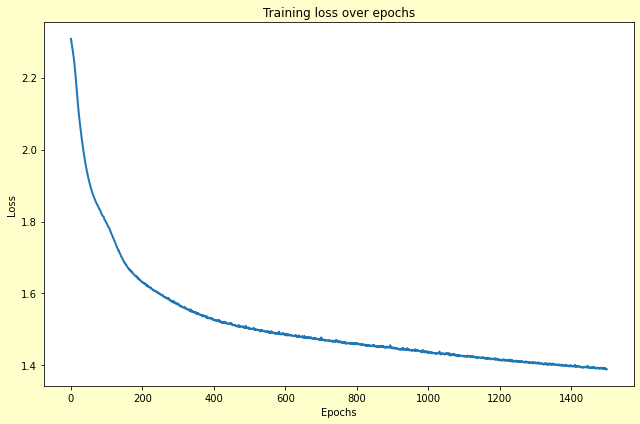

In [21]:
showChart(history.history['loss'], title='Training loss over epochs', label_y='Loss', label_x='Epochs')

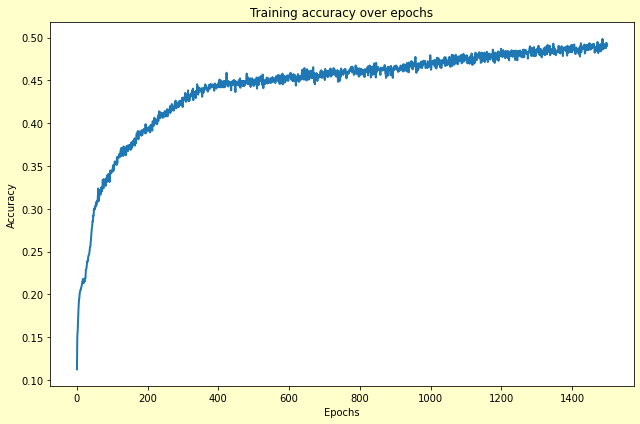

In [22]:
showChart(history.history['categorical_accuracy'], title='Training accuracy over epochs', label_y='Accuracy', label_x='Epochs')

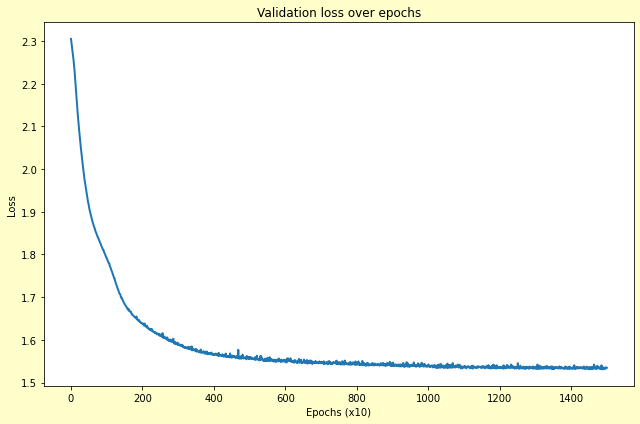

In [23]:
showChart(history.history['val_loss'], title='Validation loss over epochs', label_y='Loss', label_x='Epochs (x10)')

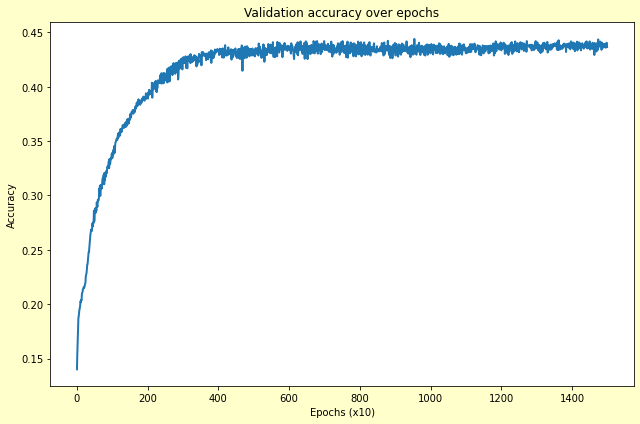

In [24]:
showChart(history.history['val_categorical_accuracy'], title='Validation accuracy over epochs', label_y='Accuracy', label_x='Epochs (x10)')

#Testing

# Error Analysis

# Insights